In [4]:
!pip install PyWavelets
from google.colab import drive
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pywt  # For Discrete Wavelet Transform (DWT)
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
!pip install antropy
import antropy as ant  # For Approximate and Fuzzy Entropy
!pip install hurst
from hurst import compute_Hc  # For Hurst Exponent
from scipy.io import savemat


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Define input and output folders
input_folder = "/content/drive/MyDrive/EEG Dataset"
processed_folder = os.path.join(input_folder, "Processed_CNN_BiLSTM")
model_save_folder = os.path.join(input_folder, "Models_CNN_BiLSTM")
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(model_save_folder, exist_ok=True)

Mounted at /content/drive


In [40]:
# Define label mapping for 3-class classification
label_map = {"F": 0, "N": 0, "O": 1, "Z": 1, "S": 2}  # Three-class classification

# Function to apply band-pass filter
def bandpass_filter(signal, lowcut=0.5, highcut=50, fs=173.61, order=4):
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Feature Extraction Function
def extract_features(signal):
    coeffs = pywt.wavedec(signal, wavelet='db4', level=4)
    dwt_features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    apen = ant.app_entropy(signal)
    fuen = ant.perm_entropy(signal, order=2, normalize=True)
    rms = np.sqrt(np.mean(signal**2))
    hurst_exp, _, _ = compute_Hc(signal, kind='random_walk')
    return np.array(dwt_features + [apen, fuen, rms, hurst_exp])

In [46]:
# Load and preprocess data
all_features, all_labels = [], []
for folder in label_map.keys():
    folder_path = os.path.join(input_folder, folder)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} not found. Skipping...")
        continue

    for file in os.listdir(folder_path):
        if file.endswith(".txt") or file.endswith(".TXT"):
            file_path = os.path.join(folder_path, file)
            signal = np.loadtxt(file_path)
            filtered_signal = bandpass_filter(signal)
            scaler = StandardScaler()
            normalized_signal = scaler.fit_transform(filtered_signal.reshape(-1, 1)).flatten()
            features = extract_features(normalized_signal)
            all_features.append(features)
            all_labels.append(label_map[folder])

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)
y = LabelEncoder().fit_transform(y)
num_classes = len(np.unique(y))
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)

In [47]:
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
# Define CNN-BiLSTM model (following the exact architecture from the paper)
def create_cnn_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape, 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=False)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train model
model = create_cnn_bilstm_model(input_shape=X.shape[1], num_classes=num_classes)
model.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 14, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 14, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 7, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 7, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 3, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_20 (Bidirectional)     │ (None, 1, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,587 (1.30 MB)

 Trainable params: 338,691 (1.29 MB)

 Non-trainable params: 896 (3.50 KB)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=30 > n_features=14. There will be no feature selection and all features will be kept.
  warnings.warn(


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5594 - loss: 1.0299 - val_accuracy: 0.5000 - val_loss: 1.0867
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7912 - loss: 0.6945 - val_accuracy: 0.7800 - val_loss: 1.0615
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8088 - loss: 0.5174 - val_accuracy: 0.4200 - val_loss: 1.0606
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8534 - loss: 0.3866 - val_accuracy: 0.4000 - val_loss: 1.0618
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9097 - loss: 0.2883 - val_accuracy: 0.4000 - val_loss: 1.0747
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9510 - loss: 0.1903 - val_accuracy: 0.4000 - val_loss: 1.0767
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9331 - loss: 0.2139 - val_accuracy: 0.4000 - val_loss: 1.0976
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9511 - loss: 0.1664 - val_accuracy: 0.4000 - val_los

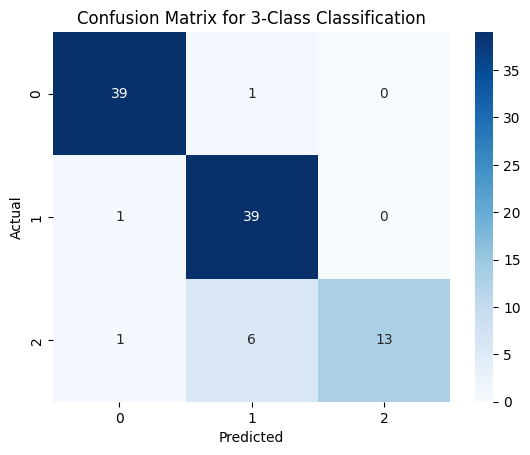

In [48]:
# Train-Test Split Before Feature Selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Feature Selection After Splitting
svm = SVC(kernel='linear')
rfe = RFE(svm, n_features_to_select=30)  # Keep more features to avoid losing useful information
X_train_selected = rfe.fit_transform(X_train, np.argmax(y_train, axis=1))
X_test_selected = rfe.transform(X_test)  # Apply the same transformation

# Reshape for CNN-BiLSTM
X_train_selected = X_train_selected.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
X_test_selected = X_test_selected.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# Train BiLSTM Model
model = create_cnn_bilstm_model(input_shape=X_train_selected.shape[1], num_classes=num_classes)
history = model.fit(X_train_selected, y_train, epochs=100, batch_size=64, validation_data=(X_test_selected, y_test), verbose=1)

# Evaluate the Model
y_pred = model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for 3-Class Classification')
plt.show()


In [49]:
# Save model
model.save(os.path.join(model_save_folder, "cnn_bilstm_3class.h5"))